# CAT10 BAYESIAN :D :D :D :D :D

In [1]:
import sys

from skopt import gp_minimize
from skopt.space import Real, Integer

from utils.post_processing import eurm_to_recommendation_list,eurm_remove_seed, shift_rec_list_cutoff
from utils.pre_processing import norm_max_row, norm_l1_row
from utils.evaluator import Evaluator
from utils.datareader import Datareader
from utils.ensembler import ensembler
from utils.definitions import *

import scipy.sparse as sps
import numpy as np
import os.path

# datareader, valutazione ed essenziali 

In [2]:
dr = Datareader(verbose=False, mode = "offline", only_load="False")
ev = Evaluator(dr)

# cat10 > impostazioni da toccare


In [29]:
target_metric = 'ndcg'
best_score = 0 
best_params = 0
norm = norm_max_row
verbose = True
# memory_on_disk= False
memory_on_notebook=True

### impostazioni da NON toccare

In [31]:
cat = 10 
start_index = 9000
end_index = 10000
global_counter=0
x0 = None
y0 = None

# files e matrici

In [18]:
path = ROOT_DIR+'/npz_simo/'
cb_ar_file = path+"cb_ar_offline.npz"
cb_al_file = path+"cb_al_offline.npz"
cb_al_ar_file = path+"cb_al_offline.npz"
cf_ib_file = path+"cf_ib_offline.npz"
cf_ub_file = path+"cf_ub_offline.npz"



In [19]:
cb_ar = norm( eurm_remove_seed( sps.load_npz(cb_ar_file) ,dr)[start_index:end_index] )
cb_al = norm( eurm_remove_seed( sps.load_npz(cb_al_file) ,dr)[start_index:end_index] )
cb_al_ar = norm( eurm_remove_seed( sps.load_npz(cb_al_file) ,dr)[start_index:end_index] )
cf_ib = norm( eurm_remove_seed( sps.load_npz(cf_ib_file) ,dr)[start_index:end_index] )
cf_ub = norm( eurm_remove_seed( sps.load_npz(cf_ub_file) ,dr)[start_index:end_index] )

In [20]:
matrices_names =  ['cb_ar', 'cb_al', 'cb_al_ar', 'cf_ib', 'cf_ub']
matrices_array =  [ cb_ar,   cb_al,  cb_al_ar ,  cf_ib ,  cf_ub ]

In [21]:
matrices = dict(zip(matrices_names, matrices_array   ))

# funzione obiettivo
il numero di matrici e l'ordine va rispettato 

In [22]:

def obiettivo( x ):
    global best_score,global_counter, best_params, x0, y0
    
#     eurm = x[0]*cb_ar +  x[1]*cb_al   +  x[2]*cf_ib  +  x[3]*cf_ub
    eurm = sum( x[i]*matrix for i,matrix in enumerate(matrices_array))
    
    # real objective function
    ris = -ev.evaluate_single_metric(eurm_to_recommendation_list(eurm, cat=cat, remove_seed=False, verbose=False),
                                     verbose=False,
                                      cat=cat, 
                                      name="ens"+str(cat), 
                                      metric=target_metric,
                                      level='track')
    # memory variables 
    if x0 is None:
        x0 = [[x]]
        y0 = [ris]
    else:
        x0.append(x)
        y0.append(ris)
    
    global_counter+=1
    if ris < best_score :
        print("[NEW BEST]")
        pretty_print(ris,x)
        best_score= ris
        best_params = x.copy()
        best_params_dict = dict(zip(matrices_names,x.copy()))
    elif verbose:
        pretty_print(ris,x)
        

    return ris

In [23]:
def pretty_print(ris, x):
    print(global_counter,"RES:",ris, end="\tvals:\t")
    for i in range(len(x)):
        print(matrices_names[i],"%.2f" % (x[i]), end="\t")
    print( )

# parameters 

In [26]:

# The list of hyper-parameters we want to optimize. For each one we define the bounds,
# the corresponding scikit-learn parameter name, as well as how to sample values
# from that dimension (`'log-uniform'` for the learning rate)

space  = [Real(0, 100, name=x) for x in matrices_names]

#"log-uniform",

In [27]:
space

[Real(low=1, high=100, prior='uniform', transform='identity'),
 Real(low=1, high=100, prior='uniform', transform='identity'),
 Real(low=1, high=100, prior='uniform', transform='identity'),
 Real(low=1, high=100, prior='uniform', transform='identity'),
 Real(low=1, high=100, prior='uniform', transform='identity')]

In [ ]:
res = gp_minimize(obiettivo,  space, 
            base_estimator=None,
            n_calls=300, n_random_starts=100, 
            acq_func='gp_hedge', 
            acq_optimizer='auto', 
            x0=x0, y0=y0, 
            random_state=None, verbose=False, 
            callback=None, n_points=10000, 
            n_restarts_optimizer=10, 
            xi=0.01, kappa=1.96, 
            noise='gaussian', n_jobs=-1)

[NEW BEST]
1 RES: -0.37378356962623166	vals:	cb_ar 68.70	cb_al 36.08	cb_al_ar 36.30	cf_ib 97.42	cf_ub 3.51	
[NEW BEST]
2 RES: -0.3891175215489976	vals:	cb_ar 92.66	cb_al 71.79	cb_al_ar 17.38	cf_ib 60.03	cf_ub 73.31	
[NEW BEST]
3 RES: -0.3918396200652956	vals:	cb_ar 32.14	cb_al 3.67	cb_al_ar 89.28	cf_ib 18.89	cf_ub 49.79	
4 RES: -0.3681843676950389	vals:	cb_ar 68.26	cb_al 20.39	cb_al_ar 84.16	cf_ib 54.88	cf_ub 34.09	
5 RES: -0.38779062549510346	vals:	cb_ar 48.68	cb_al 36.44	cb_al_ar 94.99	cf_ib 48.16	cf_ub 52.41	
6 RES: -0.3468314270077412	vals:	cb_ar 58.85	cb_al 66.87	cb_al_ar 5.02	cf_ib 32.62	cf_ub 23.44	
[NEW BEST]
7 RES: -0.4499732387647143	vals:	cb_ar 10.77	cb_al 45.99	cb_al_ar 69.17	cf_ib 63.79	cf_ub 88.75	
8 RES: -0.3817439009429091	vals:	cb_ar 65.59	cb_al 77.09	cb_al_ar 36.22	cf_ib 54.18	cf_ub 47.17	
9 RES: -0.36518887515821297	vals:	cb_ar 26.68	cb_al 67.77	cb_al_ar 79.56	cf_ib 81.66	cf_ub 6.20	
10 RES: -0.4228877854815001	vals:	cb_ar 44.06	cb_al 65.03	cb_al_ar 30.61	cf_ib 16.97

84 RES: -0.3456133258862047	vals:	cb_ar 99.35	cb_al 45.37	cb_al_ar 2.24	cf_ib 40.39	cf_ub 54.08	
85 RES: -0.4451163482440691	vals:	cb_ar 62.17	cb_al 16.64	cb_al_ar 49.41	cf_ib 78.72	cf_ub 92.25	
86 RES: -0.3464770396665246	vals:	cb_ar 92.94	cb_al 21.74	cb_al_ar 21.15	cf_ib 55.24	cf_ub 38.36	
87 RES: -0.43694218963213255	vals:	cb_ar 56.34	cb_al 10.09	cb_al_ar 14.01	cf_ib 62.52	cf_ub 82.19	
88 RES: -0.33931036268855624	vals:	cb_ar 58.13	cb_al 69.73	cb_al_ar 24.70	cf_ib 13.94	cf_ub 33.78	
89 RES: -0.4103913424438816	vals:	cb_ar 62.06	cb_al 29.43	cb_al_ar 39.24	cf_ib 78.57	cf_ub 41.58	
90 RES: -0.4799044479961349	vals:	cb_ar 6.30	cb_al 12.74	cb_al_ar 5.70	cf_ib 64.29	cf_ub 87.13	
91 RES: -0.45608079716465244	vals:	cb_ar 19.53	cb_al 18.20	cb_al_ar 15.97	cf_ib 24.12	cf_ub 44.75	
92 RES: -0.3901500844130522	vals:	cb_ar 74.09	cb_al 36.46	cb_al_ar 98.66	cf_ib 23.56	cf_ub 92.17	
93 RES: -0.37180482482892185	vals:	cb_ar 56.34	cb_al 60.06	cb_al_ar 31.02	cf_ib 21.11	cf_ub 49.80	
94 RES: -0.40526502

167 RES: -0.4661658524661788	vals:	cb_ar 1.01	cb_al 72.23	cb_al_ar 32.10	cf_ib 90.17	cf_ub 99.42	
168 RES: -0.4832404757380326	vals:	cb_ar 4.30	cb_al 34.11	cb_al_ar 1.00	cf_ib 82.11	cf_ub 73.51	
169 RES: -0.4830847897948328	vals:	cb_ar 7.13	cb_al 21.15	cb_al_ar 18.76	cf_ib 100.00	cf_ub 74.68	
170 RES: -0.4823301696284251	vals:	cb_ar 12.71	cb_al 37.05	cb_al_ar 11.91	cf_ib 99.78	cf_ub 95.42	
171 RES: -0.4515007842888201	vals:	cb_ar 28.02	cb_al 39.13	cb_al_ar 96.92	cf_ib 96.29	cf_ub 99.87	
172 RES: -0.48330178063930496	vals:	cb_ar 5.43	cb_al 15.50	cb_al_ar 20.09	cf_ib 80.77	cf_ub 71.84	
173 RES: -0.48315812783826856	vals:	cb_ar 4.57	cb_al 1.00	cb_al_ar 33.68	cf_ib 80.53	cf_ub 76.38	
174 RES: -0.48192163170709706	vals:	cb_ar 1.00	cb_al 42.91	cb_al_ar 1.00	cf_ib 100.00	cf_ub 100.00	
175 RES: -0.4831983283507807	vals:	cb_ar 4.90	cb_al 34.75	cb_al_ar 1.00	cf_ib 83.88	cf_ub 74.63	
176 RES: -0.4630059205118018	vals:	cb_ar 1.53	cb_al 6.41	cb_al_ar 50.34	cf_ib 4.02	cf_ub 95.28	
177 RES: -0.453024

In [7]:
best_score

0

In [8]:
best_params

0

# plot

In [86]:
from skopt.plots import plot_convergence, plot_objective
import skopt.plots
import matplotlib.pyplot as plt
%matplotlib inline

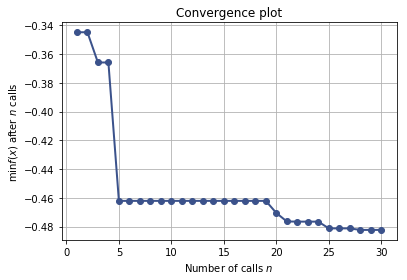

In [87]:
plot_convergence(res)

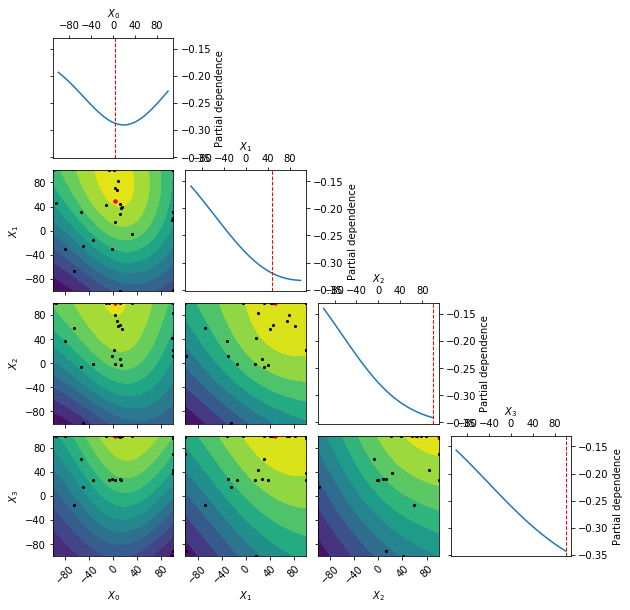

In [88]:
a = plot_objective(res)
['cb_ar', 'cb_al','cf_ib', 'cf_ub']

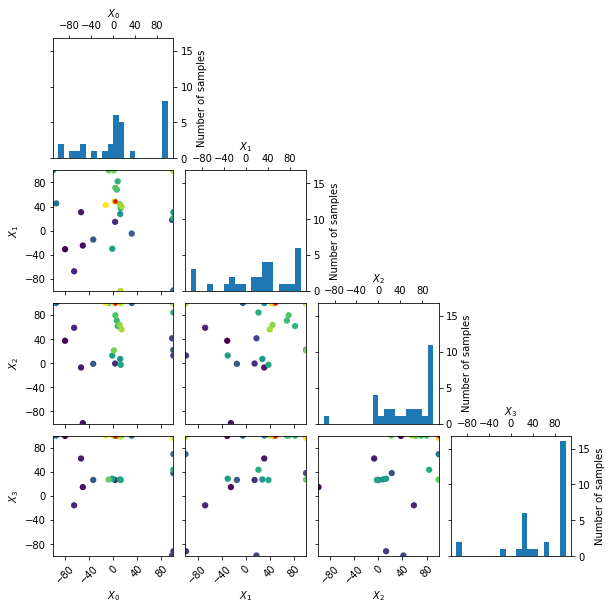

In [90]:
a = skopt.plots.plot_evaluations(res)